In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.io import loadmat
from scipy.signal import spectrogram

In [2]:
erp_mat = loadmat('ERP_data.mat')
erp_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Properties', 'Markers', 'EEGData', 'EEGPosition', 'EEGPoints', 'EEGChannelList', 'ep', 'EEGTime', 'FileName', 'NodeName', 'Analyzer', 'fname', 'pname', 'EEGSegments'])

In [3]:
trials = erp_mat['EEGData'].shape[2]
dlength = erp_mat['EEGData'].shape[0]
erp_arr = np.zeros([trials, dlength])

for t in range(trials):
    erp_arr[t, :] = erp_mat['EEGData'][:, 0, t]

erp = np.mean(erp_arr, axis=0)

erp_fs = 512 # 1 / np.diff(erp_mat['EEGTime'].ravel())[0]
erp_N = erp.shape[0]
erp_time = erp_mat['EEGTime'].ravel() # np.linspace(0, erp_N / fs, erp_N, endpoint=False)

In [4]:
1 / np.diff(erp_mat['EEGTime'].ravel())[0]

0.512

In [5]:
ssvep_mat = loadmat('SSVEP_data.mat')
ssvep_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Properties', 'Markers', 'EEGData', 'EEGPosition', 'EEGPoints', 'EEGChannelList', 'ep', 'EEGTime', 'FileName', 'NodeName', 'Analyzer', 'fname', 'pname', 'EEGSegments'])

In [6]:
trials = ssvep_mat['EEGData'].shape[2]
dlength = ssvep_mat['EEGData'].shape[0]
ssvep_arr = np.zeros([trials, dlength])

for t in range(trials):
    ssvep_arr[t, :] = ssvep_mat['EEGData'][:, 0, t]

ssvep = np.mean(ssvep_arr, axis=0)

ssvep_fs = 256 # 1 / np.diff(ssvep_mat['EEGTime'].ravel())[0]
ssvep_N = ssvep.shape[0]
ssvep_time = ssvep_mat['EEGTime'].ravel() # np.linspace(0, ssvep_N / fs, ssvep_N, endpoint=False)

In [7]:
1 / np.diff(ssvep_mat['EEGTime'].ravel())[0]

0.256

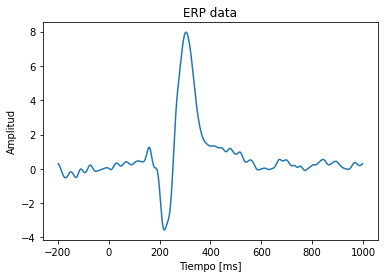

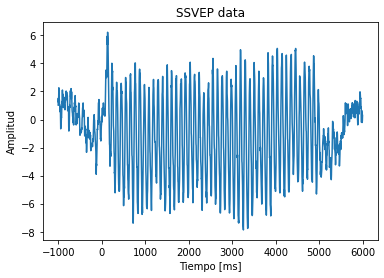

In [49]:
fig, ax = plt.subplots()
ax.plot(erp_time, erp)
ax.set_title('ERP data')
ax.set_xlabel('Tiempo [ms]')
ax.set_ylabel('Amplitud')
fig.savefig('erp_full_mean.png')

fig, ax = plt.subplots()
ax.plot(ssvep_time, ssvep)
ax.set_title('SSVEP data')
ax.set_xlabel('Tiempo [ms]')
ax.set_ylabel('Amplitud')
fig.savefig('ssvep_full_mean.png')

Text(0, 0.5, 'Amplitud')

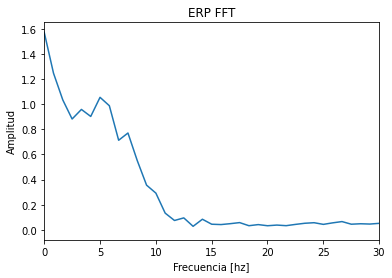

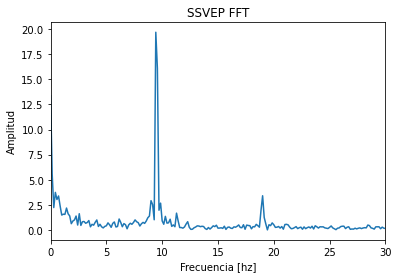

In [20]:
erp_fft = fft(erp)[:erp_N // 2]
erp_ff = fftfreq(erp_N, 1 / erp_fs)[:erp_N // 2]

ssvep_fft = fft(ssvep)[:ssvep_N // 2]
ssvep_ff = fftfreq(ssvep_N, 1 / ssvep_fs)[:ssvep_N // 2]

fig, ax = plt.subplots()
ax.plot(erp_ff, 2 / erp_fs * np.abs(erp_fft))
ax.set_xlim([0, 30])

ax.set_title('ERP FFT')
ax.set_xlabel('Frecuencia [hz]')
ax.set_ylabel('Amplitud')
fig.savefig('erp_full_fft.png')

fig, ax = plt.subplots()
ax.plot(ssvep_ff, 2 / ssvep_fs * np.abs(ssvep_fft))
ax.set_xlim([0, 30])

ax.set_title('SSVEP FFT')
ax.set_xlabel('Frecuencia [hz]')
ax.set_ylabel('Amplitud')

## AGREGAR PROMEDIACIÓN ORDENADA Y PONDERADA RESPECTIVAMENTE
- Agregar el método de Welch de la parte 1 para suavizar espectro

In [45]:
def signaltonoise(a, axis=0, ddof=0, filt=None):
    if filt is not None:
        p_signal = np.sqrt(np.mean(a[filt] ** 2))
        p_noise = np.sqrt(np.mean(a[~filt] ** 2))
        
        return(p_signal / p_noise)
    
    a = np.asanyarray(a)
    m = a.mean(axis) ** 2
    sd = a.std(axis=axis, ddof=ddof) ** 2
    return np.where(sd == 0, 0, m / sd)

def sort_by_snr(data, filt=None):
    arr = list(data)
    arr.sort(key=lambda x: signaltonoise(x, filt=filt), reverse=True)
    return np.array(arr)

def sort_by_var(data):
    arr = list(data)
    arr.sort(key=lambda x: np.var(x))
    return np.array(arr)

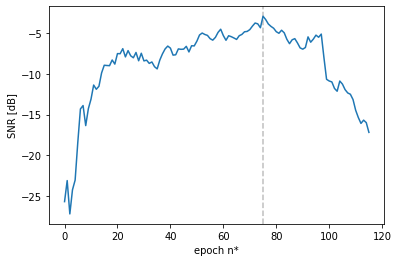

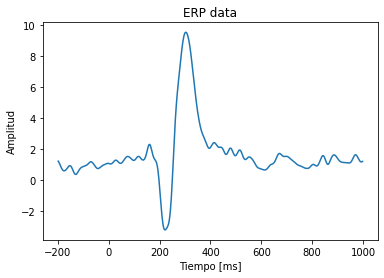

In [63]:
erp_signal_filt = (erp_time > 100) * (erp_time < 400)

s_erp_arr = sort_by_snr(erp_arr, erp_signal_filt)
s_erp_var = np.var(s_erp_arr, axis=0)

s_erp_snr = np.zeros(s_erp_arr.shape[0])
s_erp_rms = np.zeros(s_erp_arr.shape[0])

m_erp = np.zeros(s_erp_arr.shape)

for i in range(s_erp_arr.shape[0]):
    m_erp[i] = np.mean(s_erp_arr[:i + 1], axis=0)
    s_erp_snr[i] = signaltonoise(m_erp[i])
    s_erp_rms[i] = np.sqrt(np.mean(m_erp[i] ** 2))
    
max_epoch = np.argmax(s_erp_snr)

fig, ax = plt.subplots()
ax.axvline(max_epoch, linestyle='--', color='tab:gray', alpha=0.5)
ax.plot(20 * np.log10(s_erp_snr))
ax.set_xlabel('epoch n*')
ax.set_ylabel('SNR [dB]')

fig, ax = plt.subplots()
ax.plot(erp_time, m_erp[max_epoch])
ax.set_title('ERP data')
ax.set_xlabel('Tiempo [ms]')
ax.set_ylabel('Amplitud')
fig.savefig('erp_full_mean.png')

fig.savefig('erp_msnr.png')

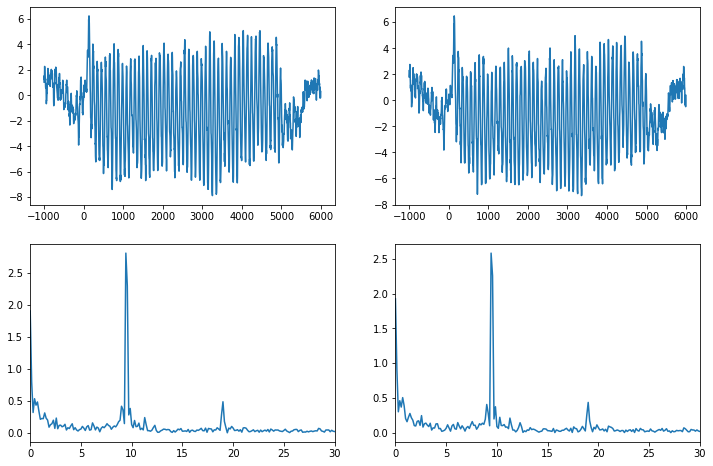

In [18]:
s_ssvep_arr = sort_by_var(ssvep_arr)
s_ssvep_var = np.var(s_ssvep_arr, axis=1)
w = 1 / (s_ssvep_var * np.sum(1 / s_ssvep_var))

w_ssvep = np.average(s_ssvep_arr, axis=0, weights=w)

w_ssvep_fft = fft(w_ssvep)[:ssvep_N // 2]

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0][0].plot(ssvep_time, ssvep)
ax[0][1].plot(ssvep_time, w_ssvep)

ax[1][0].plot(ssvep_ff, 2 / ssvep_N * np.abs(ssvep_fft))
ax[1][1].plot(ssvep_ff, 2 / ssvep_N * np.abs(w_ssvep_fft))
ax[1][0].set_xlim([0, 30])
ax[1][1].set_xlim([0, 30])

fig.savefig('ssvep_cmp.png')

In [53]:
def check_data(arr):
    print('Mean: {:.2f}, STD: {:.2f}, var: {:.2f}, SNR: {:.2f}'.format(np.mean(arr),
                                                                       np.std(arr),
                                                                       np.var(arr),
                                                                       signaltonoise(arr, filt=erp_signal_filt)))
for i in range(5):
    check_data(s_erp_arr[i])

Mean: 0.83, STD: 3.62, var: 13.09, SNR: 3.48
Mean: 0.67, STD: 2.60, var: 6.76, SNR: 3.16
Mean: 0.17, STD: 3.22, var: 10.34, SNR: 2.94
Mean: 0.97, STD: 3.16, var: 9.98, SNR: 2.89
Mean: 0.85, STD: 2.93, var: 8.59, SNR: 2.82


In [14]:
for i in range(5):
    check_data(m_erp[i])

Mean: -19.50, STD: 2.40, var: 5.78, SNR: 65.84
Mean: -4.30, STD: 2.03, var: 4.14, SNR: 4.48
Mean: 0.46, STD: 1.74, var: 3.03, SNR: 0.07
Mean: -3.44, STD: 2.23, var: 4.95, SNR: 2.39
Mean: -1.22, STD: 2.20, var: 4.83, SNR: 0.31


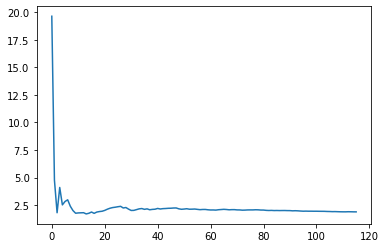

In [15]:
plt.plot(s_erp_rms)

In [16]:
s = [signaltonoise(s)[()] for s in s_erp_arr]
s[:3]

[65.83908569692159, 14.970227510554965, 13.70943096650495]

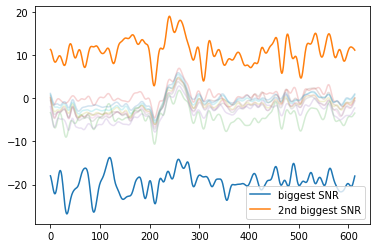

In [17]:
fig, ax = plt.subplots()

ax.plot(s_erp_arr[0], label='biggest SNR')
ax.plot(s_erp_arr[1], label='2nd biggest SNR')
for i in range(1, 10):
    ax.plot(m_erp[i], alpha=0.2)
ax.legend()
fig.savefig('first_snr.png')

In [ ]:
ssvep_arr.shape